# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import pickle

from numpy.linalg import svd, qr
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

from word2vec_as_EMF import word2vec_as_EMF

# Functions

In [2]:
# load data
def load_sentences(mode='small'):
    if (mode == 'full'):
        sentences = pickle.load(open('data/sentences_all.txt', 'rb'))
    elif (mode == 'small'):
        sentences= pickle.load(open('data/sentences1k.txt', 'rb'))
    elif (mode == 'enwik9'):
        sentences= pickle.load(open('data/enwik9_sentences.txt', 'rb'))
    return sentences

def plot_MF(MFs, x=None, xlabel='Iterations', ylabel='MF'):

    fig, ax = plt.subplots(figsize=(15, 5))
    if not x:
        ax.plot(MFs)
    else:
        ax.plot(x, MFs)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)

# Model 1000

In [3]:
model1000 = word2vec_as_EMF()

In [4]:
filename = 'enwik-1000_matrices.npz'

if not os.path.exists(filename):
    # load sentences from file
    sentences = load_sentences('enwik9')
    
    # create dictionary, matrix D, matrix B and save them to file
    model1000.data_to_matrices(data=sentences, r=1000, k=5, to_file=filename)
    print "Model was created"
    
else:
    # load dictionary, matrix D, matrix B from file
    model1000.load_matrices(from_file=filename)
    print "Model was loaded from disk"

Model was loaded from disk


In [5]:
SPPMI1000 = np.maximum(np.log(model1000.D) - np.log(model1000.B), 0)
u, s, vt = svds(SPPMI1000, k=100)
C_svd = u.dot(np.sqrt(np.diag(s))).T
W_svd = np.sqrt(np.diag(s)).dot(vt)

In [ ]:
# start projector splitting from svd of SPPMI
model1000.projector_splitting(eta=5e-6, d=100, MAX_ITER=100, 
                              init=(True, C_svd, W_svd), 
                              save=(True, 'enwik-1000_PS100iter_fromSVD_factors_step5e-6'))

In [8]:
print 5

5


In [ ]:
# calculate MF on each iteration
model1000.factors_to_MF(from_folder='enwik-1000_PS100iter_fromSVD_factors_step5e-6', 
                       to_file='enwik-1000_PS100iter_fromSVD_MF_step5e-6.npz', MAX_ITER=100)

In [17]:
# load MF
MFs = model1000.load_MF(from_file='enwik-1000_PS100iter_fromSVD_MF_step5e-6.npz')

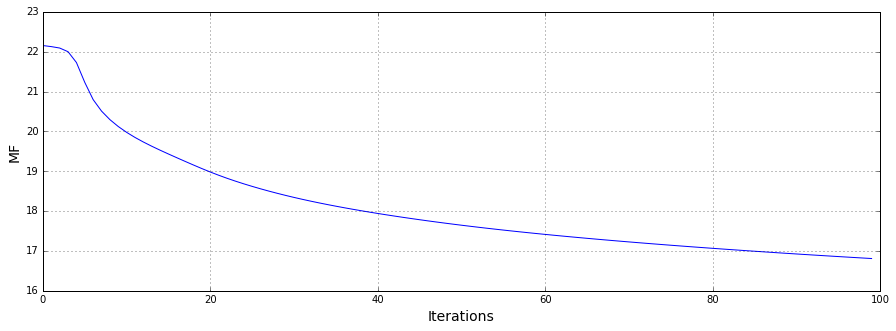

In [18]:
plot_MF(MFs)

## Wordsim353 experiment

In [28]:
wordsim353 = pd.read_csv("data/wordsim353/combined.csv")
word_sim = wordsim353.values
model_dict = model1000.dictionary
model1000.C = C_svd
model1000.W = W_svd

In [29]:
ind1 = []
ind2 = []
vec2 = []

W = model1000.W.copy()

for i in xrange(word_sim.shape[0]):
    word1 = word_sim[i][0]
    word2 = word_sim[i][1]
    if (word1 in model_dict and word2 in model_dict):
        ind1.append(int(model1000.dictionary[word1]))
        ind2.append(int(model1000.dictionary[word2]))
        vec2.append(np.float64(word_sim[i][2]))

In [36]:
vec1 = []
for i in xrange(len(vec2)):
    vec1.append(cosine(W[:,ind1[i]], W[:,ind2[i]]))
corrs = [spearmanr(vec1, vec2)[0]]

In [39]:
MAX_ITER = 100
from_folder = 'enwik-1000_PS100iter_fromSVD_factors'

for it in xrange(MAX_ITER):
    vec1 = []
    C, W = model1000.load_CW(from_folder, it+1)
    for i in xrange(len(vec2)):
        vec1.append(cosine(W[:,ind1[i]], W[:,ind2[i]]))
    corrs.append(spearmanr(vec1, vec2)[0])

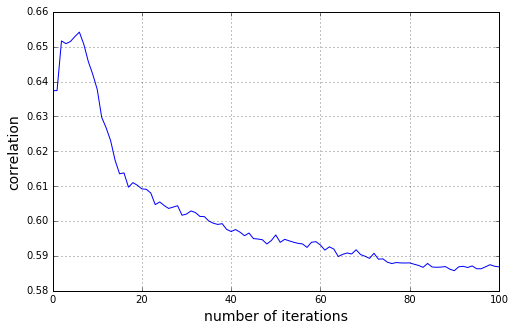

In [43]:
ps_corrs = np.array(corrs)
x = np.arange(MAX_ITER+1)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, -ps_corrs)
ax.set_xlabel('number of iterations', fontsize=14)
ax.set_ylabel('correlation', fontsize=14)
ax.grid()

# Model200

In [11]:
model200 = word2vec_as_EMF()

In [ ]:
filename = 'enwik-200_matrices.npz'

if not os.path.exists(filename):
    # load sentences from file
    #sentences = load_sentences('enwik9')
    
    # create dictionary, matrix D, matrix B and save them to file
    model200.data_to_matrices(data=sentences, r=200, k=5, to_file=filename)
    print "Model was created"
    
else:
    # load dictionary, matrix D, matrix B from file
    model200.load_matrices(from_file=filename)
    print "Model was loaded from disk"

In [44]:
len(model200.dictionary)

24294

# Loading data

In [ ]:
data = np.loadtxt("data/enwik/enwik9.txt", dtype=str, delimiter='.')

In [ ]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def wiki_to_wordlist(sentence, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    # 3. Convert words to lower case and split them
    words = sentence.split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [ ]:
sentences = []  # Initialize an empty list of sentences

print "Parsing sentences from training set"
for sentence in data:
    sentences += [wiki_to_wordlist(sentence.decode('utf-8'))]

In [ ]:
indices = []
for i, sentence in enumerate(sentences):
    if not sentence:
        pass
    else:
        indices.append(i)

In [ ]:
real_sentences = np.array(sentences)[indices]

In [ ]:
model200 = word2vec_as_EMF()

In [ ]:
filename = 'enwik-200_matrices.npz'
model200.data_to_matrices(data=list(real_sentences), r=200, k=5, to_file=filename)